In [760]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import warnings
warnings.filterwarnings('ignore')

In [761]:
surprise_housing_orig = pd.read_csv('train.csv')

In [762]:
pd.set_option('display.max_columns',None)

In [763]:
surprise_housing_orig.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Lets start with Data cleansing

##### Check utilities

In [764]:
surprise_housing_orig['Utilities'].value_counts()

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

##### Utilities has only one value for NoSewa and rest is AllPub. Hence it does not really impact model
##### Lets drop Utilities

In [765]:
surprise_housing_orig.drop('Utilities', axis= 1 , inplace=True)

In [766]:
pd.reset_option('display.max_columns')

#### Clean up LotFrontage
##### Missing value of LotFrontage is understood as actual missig data. It should not happen that in a 
##### neighbourhood few properties does not have LotFrontage. Hence replacing missing value with median of the neighbourhood

In [767]:

surprise_housing_orig['LotFrontage'] = surprise_housing_orig.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

#### Clean up Alley

In [768]:
surprise_housing_orig['Alley'].isna().value_counts()

Alley
True     1369
False      91
Name: count, dtype: int64

##### Alley has very high percentage of null values. Hence dropping this column

In [769]:

surprise_housing_orig.drop('Alley', axis = 1, inplace=True)

#### Clean up MasVnr*

In [770]:
surprise_housing_orig['MasVnrArea'].isna().value_counts()

MasVnrArea
False    1452
True        8
Name: count, dtype: int64

In [771]:
surprise_housing_orig['MasVnrType'].value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [772]:
surprise_housing_orig['MasVnrType'].isna().value_counts()

MasVnrType
True     872
False    588
Name: count, dtype: int64

##### Null values does not seems to tally between area and type. It is expected, NA type may be area zero. 
##### Lets check further

#### Check if there is an anomaly between type and area. If area is greater than 0 then type should not be na

In [773]:
## This shows a set of consistent records. Area is zero and type is NA
surprise_housing_orig[(surprise_housing_orig['MasVnrType'].isna()) & (surprise_housing_orig['MasVnrArea'] == 0 )]['MasVnrArea'].value_counts()

MasVnrArea
0.0    859
Name: count, dtype: int64

##### Lets see the distribution of of non zero areas

In [774]:
surprise_housing_orig[(surprise_housing_orig['MasVnrArea'] > 0 )][['MasVnrArea']].sort_values('MasVnrArea').head(5)

,MasVnrArea
1230,1.0
773,1.0
790,11.0
1023,14.0
229,16.0


##### Area of 1 is unrealistic. Lets see the type of that

In [775]:
surprise_housing_orig.loc[(surprise_housing_orig['MasVnrArea'] == 1 ),'MasVnrType']

773     NaN
1230    NaN
Name: MasVnrType, dtype: object

##### Here seems the area is wrong, lets update that to 0

In [776]:
## Area 1 is unrealistic. Hence we can consider Type is correct as None and hence convert 1 to 0

surprise_housing_orig.loc[(surprise_housing_orig['MasVnrType'].isna()) & (surprise_housing_orig['MasVnrArea'] == 1 ),'MasVnrArea'] = 0

##### Now one anomaly is addressed. Lets see if there are more. 


#### Are there records where type is na , but area is greater than zero



##### If MasVnrType is na and MasVnrArea > 0 , then replace MasVnrType with mode 

In [777]:
surprise_housing_orig.loc[(surprise_housing_orig['MasVnrArea'] > 0 ),'MasVnrType'].isna().value_counts()

MasVnrType
False    586
True       3
Name: count, dtype: int64

In [778]:
# For these inconsistencies replace na with mode
mode_type = surprise_housing_orig.loc[surprise_housing_orig['MasVnrType'].notna() , 'MasVnrType'].mode()[0]

In [779]:
surprise_housing_orig.loc[(surprise_housing_orig['MasVnrType'].isna()) & (surprise_housing_orig['MasVnrArea'] > 0 ),'MasVnrType']= mode_type

#### if MasVnrArea is zero and type is na, then corresponding na in MasVnrType to be replaced with none



In [780]:
surprise_housing_orig.loc[(surprise_housing_orig['MasVnrType'].isna()) & (surprise_housing_orig['MasVnrArea'] == 0),'MasVnrType'] = surprise_housing_orig.loc[(surprise_housing_orig['MasVnrType'].isna()) & (surprise_housing_orig['MasVnrArea'] == 0) , 'MasVnrType'].fillna('None') 

#### Validate if there is more na for MasVnrType

In [781]:
(surprise_housing_orig['MasVnrType'].isna()).sum()

np.int64(8)

In [782]:
(surprise_housing_orig['MasVnrArea'].isna()).sum()

np.int64(8)

#### if MasVnrArea is na and type is na, then corresponding na in MasVnrType to be replaced with none

In [783]:
noTypeArea = (surprise_housing_orig['MasVnrType'].isna()) & (surprise_housing_orig['MasVnrArea'].isna()) 

In [784]:
surprise_housing_orig.loc[noTypeArea,'MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

In [785]:

surprise_housing_orig.loc[noTypeArea,'MasVnrType'] = surprise_housing_orig.loc[noTypeArea , 'MasVnrType'].fillna('None')
surprise_housing_orig.loc[noTypeArea,'MasVnrArea'] = surprise_housing_orig.loc[noTypeArea , 'MasVnrArea'].fillna(0)

In [786]:
(surprise_housing_orig['MasVnrArea'].isna()).sum()

np.int64(0)

#### Now lets clean up basement attributes

#### if both BsmtFinType1 and BsmtFinType2 is na, other basment attribute will be na
#### All such cases are replaced by No

In [787]:
#### data series with true and fase indicating records with na or not
basement_df = (surprise_housing_orig['BsmtFinType1'].isna()) & (surprise_housing_orig['BsmtFinType2'].isna())

In [788]:
surprise_housing_orig.loc[basement_df,'BsmtQual'] = surprise_housing_orig[basement_df]['BsmtQual'].fillna('No')

In [789]:
surprise_housing_orig.loc[basement_df,'BsmtCond'] = surprise_housing_orig[basement_df]['BsmtCond'].fillna('No')

In [790]:
surprise_housing_orig.loc[basement_df,'BsmtCond'] = surprise_housing_orig[basement_df]['BsmtCond'].fillna('No')

In [791]:
surprise_housing_orig['BsmtExposure'] = surprise_housing_orig['BsmtExposure'].replace({
    'No': 'NoE'
})
surprise_housing_orig.loc[basement_df,'BsmtExposure'] = surprise_housing_orig[basement_df]['BsmtExposure'].fillna('No')

In [792]:
surprise_housing_orig.loc[basement_df,'BsmtFinType1'] = surprise_housing_orig[basement_df]['BsmtFinType1'].fillna('No')

In [793]:
surprise_housing_orig.loc[basement_df,'BsmtFinType2'] = surprise_housing_orig[basement_df]['BsmtFinType2'].fillna('No')

##### Any remaining basement NA records

In [794]:
surprise_housing_orig['BsmtExposure'].isna().value_counts()

BsmtExposure
False    1459
True        1
Name: count, dtype: int64

In [795]:
surprise_housing_orig['BsmtFinType2'].isna().value_counts()

BsmtFinType2
False    1459
True        1
Name: count, dtype: int64

In [796]:
pd.set_option('display.max_columns',None)

In [797]:
surprise_housing_orig[surprise_housing_orig['BsmtFinType2'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,IR1,Lvl,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,NoE,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000


#### BsmtFinType2 with Na above is inconsistent record, as other type to attributes are not NA.
##### Lets drop this record

In [798]:

surprise_housing_orig.drop(surprise_housing_orig[surprise_housing_orig['BsmtFinType2'].isna()].index, inplace=True)

In [799]:
pd.reset_option('display.max_columns')

In [800]:
surprise_housing_orig['BsmtFinType1'].isna().value_counts()

BsmtFinType1
False    1459
Name: count, dtype: int64

In [801]:
pd.set_option('display.max_columns',None)

In [802]:
surprise_housing_orig[surprise_housing_orig['BsmtExposure'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
948,949,60,RL,65.0,14006,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


##### Its seems to be a valid record. Replacing Na with No

In [803]:
surprise_housing_orig['BsmtExposure'] = surprise_housing_orig['BsmtExposure'].fillna('No')

In [804]:
surprise_housing_orig['BsmtCond'].isna().value_counts()

BsmtCond
False    1459
Name: count, dtype: int64

In [805]:
surprise_housing_orig.shape

(1459, 79)

In [806]:
surprise_housing_orig[surprise_housing_orig['Electrical'].isna()].index

Index([1379], dtype='int64')

##### Since only one row is havving na, we can drop it

In [807]:
surprise_housing_orig.drop(surprise_housing_orig[surprise_housing_orig['Electrical'].isna()].index, inplace=True)
##surprise_housing_orig['Electrical'] = surprise_housing_orig['Electrical'].fillna(surprise_housing_orig['Electrical'].mode()[0])

In [808]:
no_fireplace = (surprise_housing_orig['FireplaceQu'].isna()) & (surprise_housing_orig['Fireplaces'] == 0)
surprise_housing_orig.loc[no_fireplace, 'FireplaceQu'] = surprise_housing_orig[no_fireplace]['FireplaceQu'].fillna('No')

#### Clean up Garage

In [809]:
noGarage = (surprise_housing_orig['GarageType'].isna()) & (surprise_housing_orig['GarageYrBlt'].isna()) & (surprise_housing_orig['GarageFinish'].isna()) & (surprise_housing_orig['GarageCars'] == 0) & (surprise_housing_orig['GarageArea'] == 0) & (surprise_housing_orig['GarageQual'].isna()) & (surprise_housing_orig['GarageCond'].isna())

In [810]:
surprise_housing_orig.loc[noGarage, 'GarageType' ] = surprise_housing_orig[noGarage]['GarageType'].fillna('No')

In [811]:
surprise_housing_orig.loc[noGarage, 'GarageFinish' ] = surprise_housing_orig[noGarage]['GarageFinish'].fillna('No')

In [812]:
surprise_housing_orig.loc[noGarage, 'GarageYrBlt' ] = surprise_housing_orig[noGarage]['GarageYrBlt'].fillna(surprise_housing_orig[noGarage]['YearBuilt'])

In [813]:
surprise_housing_orig.loc[noGarage, 'GarageQual' ] = surprise_housing_orig[noGarage]['GarageQual'].fillna('No')

In [814]:
surprise_housing_orig.loc[noGarage, 'GarageCond' ] = surprise_housing_orig[noGarage]['GarageCond'].fillna('No')

##### Are there more records with NA

In [815]:
anyNAGarage = (surprise_housing_orig['GarageType'].isna()) | (surprise_housing_orig['GarageYrBlt'].isna()) | (surprise_housing_orig['GarageFinish'].isna()) | (surprise_housing_orig['GarageQual'].isna()) | (surprise_housing_orig['GarageCond'].isna())


In [816]:
surprise_housing_orig[anyNAGarage].value_counts()

Series([], Name: count, dtype: int64)

##### Data cleaning done for Garage



#### Clean up pool attributes

In [817]:
noPool = (surprise_housing_orig['PoolQC'].isna()) & (surprise_housing_orig['PoolArea'] == 0) 
surprise_housing_orig.loc[noPool,'PoolQC'] = surprise_housing_orig[noPool]['PoolQC'].fillna('No')

In [818]:
surprise_housing_orig['PoolQC'].isna().value_counts()

PoolQC
False    1458
Name: count, dtype: int64

In [819]:
surprise_housing_orig['PoolArea'].isna().value_counts()

PoolArea
False    1458
Name: count, dtype: int64

In [820]:
surprise_housing_orig['Fence'].value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

In [821]:
surprise_housing_orig['Fence'] = surprise_housing_orig['Fence'].fillna('No')

In [822]:
surprise_housing_orig['MiscFeature'].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [823]:
surprise_housing_orig['MiscFeature'] = surprise_housing_orig['MiscFeature'].fillna('None')

### Lets define some derived attributes based on the domain 




In [824]:
# House/Remodel/Garage age at sale
surprise_housing_orig['HouseAge'] = surprise_housing_orig['YrSold'] - surprise_housing_orig['YearBuilt']
surprise_housing_orig['RemodAge'] = surprise_housing_orig['YrSold'] - surprise_housing_orig['YearRemodAdd']
surprise_housing_orig['GarageAge'] = surprise_housing_orig['YrSold'] - surprise_housing_orig['GarageYrBlt']

In [825]:
# Total bathrooms (weighted halves)
surprise_housing_orig['TotalBath'] = (surprise_housing_orig['FullBath'] + 0.5 * surprise_housing_orig['HalfBath'] +
                   surprise_housing_orig['BsmtFullBath'] + 0.5 * surprise_housing_orig['BsmtHalfBath'])


In [826]:
# Porch total
surprise_housing_orig['TotalPorchSF'] = (surprise_housing_orig['OpenPorchSF'] + surprise_housing_orig['EnclosedPorch'] +
                      surprise_housing_orig['3SsnPorch'] + surprise_housing_orig['ScreenPorch'])

In [827]:
 # Total finished basement area and total SF
surprise_housing_orig['FinBsmtSF'] = surprise_housing_orig['BsmtFinSF1'] + surprise_housing_orig['BsmtFinSF2']
surprise_housing_orig['TotalSF'] = surprise_housing_orig['TotalBsmtSF'] + surprise_housing_orig['1stFlrSF'] + surprise_housing_orig['2ndFlrSF']


In [828]:
# Has features binary flags
surprise_housing_orig['HasPool'] = (surprise_housing_orig['PoolArea']> 0).astype(int)
surprise_housing_orig['HasGarage'] = (surprise_housing_orig['GarageArea'] > 0).astype(int)
surprise_housing_orig['HasBsmt'] = (surprise_housing_orig['TotalBsmtSF'] > 0).astype(int)
surprise_housing_orig['HasPorch'] = (surprise_housing_orig['TotalPorchSF'] > 0).astype(int)

In [829]:
surprise_housing_orig_copy = surprise_housing_orig.copy()

### Now categorize variables - Categorical, Ordinal Categorical, Numeric

In [830]:
## Numeric variables
numv = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF','GrLivArea', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'HouseAge', 'RemodAge', 'GarageAge', 'TotalBath', 'TotalPorchSF', 'FinBsmtSF', 'TotalSF', 'SalePrice']

In [831]:
surprise_housing_orig_copy[numv].corr()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,HouseAge,RemodAge,GarageAge,TotalBath,TotalPorchSF,FinBsmtSF,TotalSF,SalePrice
LotFrontage,1.000000,0.336011,0.195523,0.232273,0.051184,0.118397,0.382482,0.434104,0.076028,0.031943,0.385185,0.338740,0.089104,0.142183,0.008252,0.064728,0.041217,0.174631,0.005380,0.245187,-0.005514,0.332531,0.249251,0.280935,0.106881,0.006751,0.186245,0.054477,-0.120160,-0.083846,-0.089883,0.219695,0.134270,0.240109,0.448089,0.349562
LotArea,0.336011,1.000000,0.103328,0.214270,0.111407,-0.002668,0.263091,0.299671,0.051049,0.004774,0.263111,0.180599,0.171741,0.084772,-0.018357,0.020418,0.043151,0.077670,0.038064,0.119700,-0.017794,0.190040,0.271426,0.155022,0.158203,0.048037,0.126120,0.014343,-0.014895,-0.014768,-0.004437,0.204855,0.071307,0.243242,0.308060,0.263978
MasVnrArea,0.195523,0.103328,1.000000,0.260196,-0.073627,0.112259,0.359319,0.339023,0.174791,-0.068621,0.388006,0.370018,0.160671,0.122875,-0.109855,0.019194,0.062376,0.011958,-0.029560,0.102771,-0.038414,0.279614,0.246435,0.361391,0.081980,0.027501,0.272983,0.200378,-0.311590,-0.177093,-0.267259,0.313938,0.051980,0.224610,0.443576,0.472114
BsmtFinSF1,0.232273,0.214270,0.260196,1.000000,-0.053242,-0.499438,0.521659,0.444800,-0.136017,-0.064531,0.208029,0.295496,0.205369,0.112172,-0.102296,0.026521,0.062188,0.140669,0.003607,-0.107532,-0.081022,0.044261,0.259157,0.223032,0.648660,0.067581,0.058350,0.005869,-0.248680,-0.127597,-0.183733,0.481540,0.051575,0.941051,0.414043,0.385626
BsmtFinSF2,0.051184,0.111407,-0.073627,-0.053242,1.000000,-0.214638,0.096619,0.095012,-0.097948,0.015042,-0.010108,-0.021876,0.069477,0.004261,0.037229,-0.029877,0.089543,0.041927,0.005096,-0.016037,-0.040507,-0.035805,0.045764,-0.041378,0.156975,0.071525,-0.077968,-0.030605,0.052226,0.071428,0.065550,0.050078,0.063476,0.287682,0.043891,-0.013839
BsmtUnfSF,0.118397,-0.002668,0.112259,-0.499438,-0.214638,1.000000,0.411578,0.316643,0.005951,0.028381,0.240320,0.180729,-0.004103,0.130235,-0.002066,0.020959,-0.012246,-0.035070,-0.023767,0.166754,0.030426,0.250757,0.050460,0.212229,-0.426018,-0.095675,0.288525,-0.039651,-0.149730,-0.183208,-0.176635,-0.106256,0.080191,-0.551712,0.370830,0.212884
TotalBsmtSF,0.382482,0.263091,0.359319,0.521659,0.096619,0.411578,1.000000,0.822549,-0.172768,-0.033270,0.458071,0.484929,0.236786,0.251253,-0.095524,0.037997,0.085896,0.127367,-0.018444,0.050531,-0.069041,0.287513,0.339732,0.433722,0.305741,0.000244,0.324986,-0.045402,-0.393184,-0.293140,-0.347480,0.415410,0.158897,0.533045,0.826361,0.614982
1stFlrSF,0.434104,0.299671,0.339023,0.444800,0.095012,0.316643,0.822549,1.000000,-0.201755,-0.014241,0.566197,0.489019,0.236368,0.212003,-0.065318,0.056166,0.088869,0.131649,-0.021105,0.127499,0.068184,0.409872,0.409885,0.438990,0.243535,0.001982,0.381056,-0.118587,-0.282609,-0.241731,-0.266472,0.390491,0.158371,0.458787,0.800422,0.605546
2ndFlrSF,0.076028,0.051049,0.174791,-0.136017,-0.097948,0.005951,-0.172768,-0.201755,1.000000,0.063367,0.688004,0.139772,0.091787,0.208114,0.061987,-0.024377,0.040601,0.081512,0.016196,0.503110,0.059312,0.616714,0.195483,0.184929,-0.168686,-0.023885,0.421782,0.609390,-0.011590,-0.142032,-0.061182,0.375826,0.181864,-0.163631,0.345820,0.320425
LowQualFinSF,0.031943,0.004774,-0.068621,-0.064531,0.015042,0.028381,-0.033270,-0.014241,0.063367,1.000000,0.134688,-0.067560,-0.025507,0.018141,0.061028,-0.004315,0.026756,0.062147,-0.003807,0.105637,0.007487,0.131243,-0.021311,-0.094410,-0.047151,-0.005882,-0.000580,-0.027061,0.182197,0.060453,0.104166,-0.041106,0.059886,-0.056795,0.009383,-0.025528


In [832]:
##Categorical variables
categ = ['MSSubClass', 'MSZoning', 'Street', 'LandContour','LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'SaleType',
        'SaleCondition', 'Exterior1st', 'Exterior2nd', 'MasVnrType','RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 'BsmtFinType1', 'BsmtFinType2',
        'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'Electrical']


In [833]:
## Ordinal variables
ordnl = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual', 'HeatingQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
        'BsmtExposure', 'LotShape', 'LandSlope', 'PavedDrive', 'Functional', 'OverallQual', 'OverallCond'] 

####  Now lets start processing the ordinal variables

In [834]:
lotshape_map = {
    "IR3": 1,
    "IR2": 2,
    "IR1": 3,
    "Reg": 4
}
surprise_housing_orig['LotShape'] = surprise_housing_orig['LotShape'].map(lotshape_map)



In [835]:
 quality_map = {
    "No": 0,
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}
surprise_housing_orig['ExterQual']    = surprise_housing_orig['ExterQual'].map(quality_map)
surprise_housing_orig['ExterCond']    = surprise_housing_orig['ExterCond'].map(quality_map)
surprise_housing_orig['BsmtQual']     = surprise_housing_orig['BsmtQual'].map(quality_map)
surprise_housing_orig['BsmtCond']     = surprise_housing_orig['BsmtCond'].map(quality_map)
surprise_housing_orig['HeatingQC']    = surprise_housing_orig['HeatingQC'].map(quality_map)
surprise_housing_orig['KitchenQual']  = surprise_housing_orig['KitchenQual'].map(quality_map)
surprise_housing_orig['FireplaceQu']  = surprise_housing_orig['FireplaceQu'].map(quality_map)
surprise_housing_orig['GarageQual']   = surprise_housing_orig['GarageQual'].map(quality_map)
surprise_housing_orig['GarageCond']   = surprise_housing_orig['GarageCond'].map(quality_map)
surprise_housing_orig['PoolQC']       = surprise_housing_orig['PoolQC'].map(quality_map)

In [836]:
bsmtexposure_map = {
    "No": 0,
    "NoE" : 1,
    "Mn": 2,
    "Av": 3,
    "Gd": 4
}
surprise_housing_orig['BsmtExposure'] = surprise_housing_orig['BsmtExposure'].map(bsmtexposure_map)


In [837]:
landslope_map = {
    "Sev": 1,
    "Mod": 2,
    "Gtl": 3
}
surprise_housing_orig['LandSlope'] = surprise_housing_orig['LandSlope'].map(landslope_map)

In [838]:
paveddrive_map = {
    'Y': 2,   # Paved
    'P': 1,   # Partial
    'N': 0    # Dirt/Gravel
}
surprise_housing_orig['PavedDrive'] = surprise_housing_orig['PavedDrive'].map(paveddrive_map)

In [839]:
functional_map = {
    'Typ': 0,   
    'Min1': 1,  
    'Min2': 2,  
    'Mod': 3,   
    'Maj1': 4,  
    'Maj2': 5,  
    'Sev': 6,   
    'Sal': 7    
}
surprise_housing_orig['Functional'] = surprise_housing_orig['Functional'].map(functional_map)

#### Start processing categorical variables

##### Lets see some trend with categorrical variables.
##### Qverall Quality is already represented with numbers in input dats and others are covereted

##### Start with overall quality

Text(0.5, 1.0, 'OverallQual vs SalePrice')

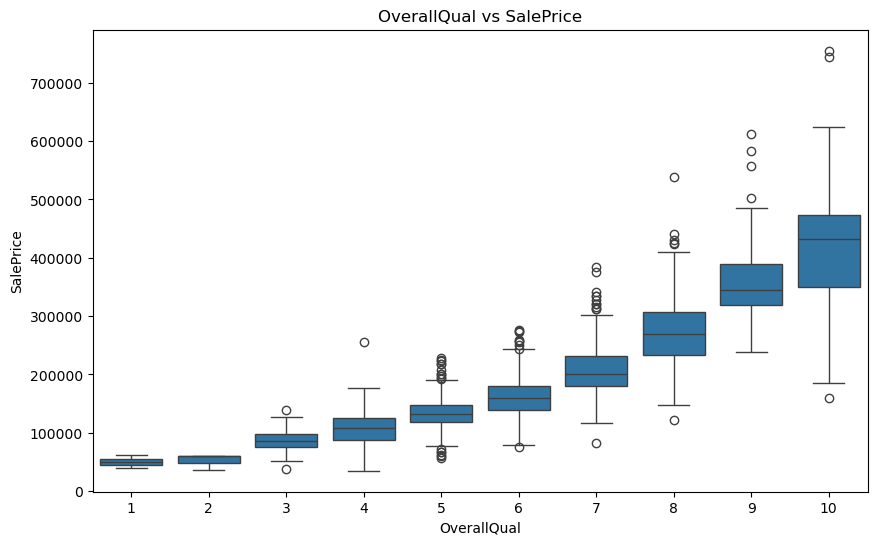

In [840]:
plt.figure( figsize=(10,6) )
sns.boxplot( x=surprise_housing_orig['OverallQual'] , y=surprise_housing_orig['SalePrice'] )
plt.title('OverallQual vs SalePrice')

##### It is showing some trend with sale price, lets see the model result later

#### Now lets see for overall condition

Text(0.5, 1.0, 'OverallCond vs SalePrice')

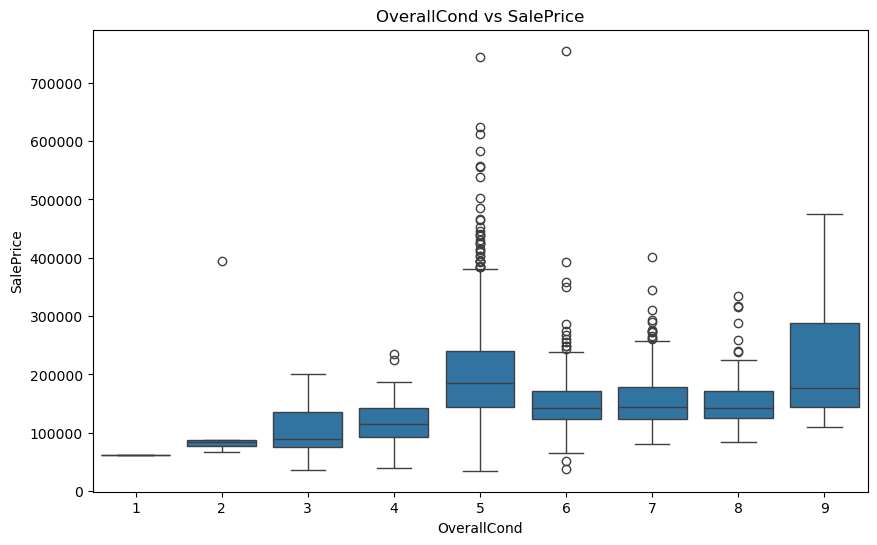

In [841]:
plt.figure( figsize=(10,6) )
sns.boxplot( x=surprise_housing_orig['OverallCond'] , y=surprise_housing_orig['SalePrice'] )
plt.title('OverallCond vs SalePrice')

##### We would not expect overall condition as important predictor

##### Now lets check for exterior quality

Text(0.5, 1.0, 'ExterQual vs SalePrice')

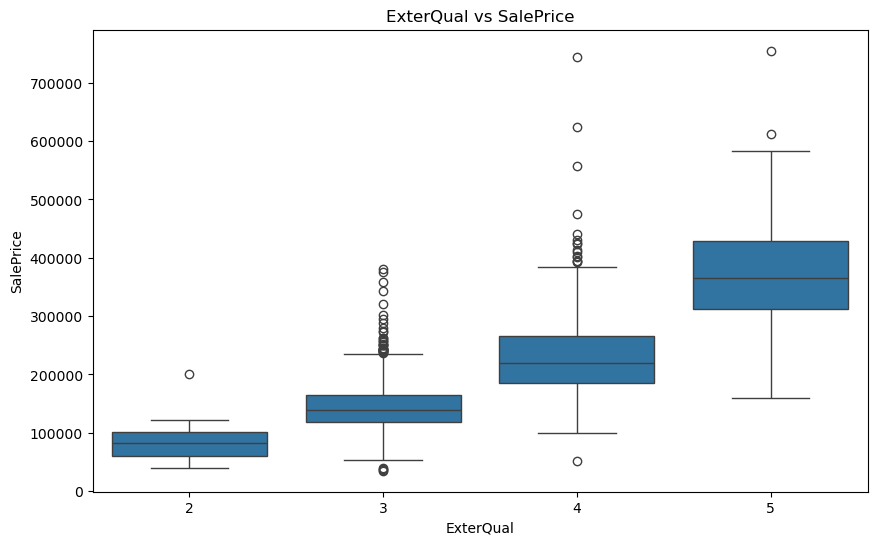

In [842]:
plt.figure( figsize=(10,6) )
sns.boxplot( x=surprise_housing_orig['ExterQual'] , y=surprise_housing_orig['SalePrice'] )
plt.title('ExterQual vs SalePrice')

##### We should also get a good trend with exterial quality
##### Now lets see what we get from the model

#### Get dummies for categorical variables now

In [843]:
surprise_housing_orig = pd.get_dummies(surprise_housing_orig,columns = categ, drop_first=True, dtype=int)

In [844]:
surprise_housing = surprise_housing_orig.copy()

In [845]:
surprise_housing.drop('Id',axis=1,inplace=True)

##### Let see the correlation between different predictor variables

In [846]:
surprise_housing[numv].corr()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,HouseAge,RemodAge,GarageAge,TotalBath,TotalPorchSF,FinBsmtSF,TotalSF,SalePrice
LotFrontage,1.000000,0.336011,0.195523,0.232273,0.051184,0.118397,0.382482,0.434104,0.076028,0.031943,0.385185,0.338740,0.089104,0.142183,0.008252,0.064728,0.041217,0.174631,0.005380,0.245187,-0.005514,0.332531,0.249251,0.280935,0.106881,0.006751,0.186245,0.054477,-0.120160,-0.083846,-0.089883,0.219695,0.134270,0.240109,0.448089,0.349562
LotArea,0.336011,1.000000,0.103328,0.214270,0.111407,-0.002668,0.263091,0.299671,0.051049,0.004774,0.263111,0.180599,0.171741,0.084772,-0.018357,0.020418,0.043151,0.077670,0.038064,0.119700,-0.017794,0.190040,0.271426,0.155022,0.158203,0.048037,0.126120,0.014343,-0.014895,-0.014768,-0.004437,0.204855,0.071307,0.243242,0.308060,0.263978
MasVnrArea,0.195523,0.103328,1.000000,0.260196,-0.073627,0.112259,0.359319,0.339023,0.174791,-0.068621,0.388006,0.370018,0.160671,0.122875,-0.109855,0.019194,0.062376,0.011958,-0.029560,0.102771,-0.038414,0.279614,0.246435,0.361391,0.081980,0.027501,0.272983,0.200378,-0.311590,-0.177093,-0.267259,0.313938,0.051980,0.224610,0.443576,0.472114
BsmtFinSF1,0.232273,0.214270,0.260196,1.000000,-0.053242,-0.499438,0.521659,0.444800,-0.136017,-0.064531,0.208029,0.295496,0.205369,0.112172,-0.102296,0.026521,0.062188,0.140669,0.003607,-0.107532,-0.081022,0.044261,0.259157,0.223032,0.648660,0.067581,0.058350,0.005869,-0.248680,-0.127597,-0.183733,0.481540,0.051575,0.941051,0.414043,0.385626
BsmtFinSF2,0.051184,0.111407,-0.073627,-0.053242,1.000000,-0.214638,0.096619,0.095012,-0.097948,0.015042,-0.010108,-0.021876,0.069477,0.004261,0.037229,-0.029877,0.089543,0.041927,0.005096,-0.016037,-0.040507,-0.035805,0.045764,-0.041378,0.156975,0.071525,-0.077968,-0.030605,0.052226,0.071428,0.065550,0.050078,0.063476,0.287682,0.043891,-0.013839
BsmtUnfSF,0.118397,-0.002668,0.112259,-0.499438,-0.214638,1.000000,0.411578,0.316643,0.005951,0.028381,0.240320,0.180729,-0.004103,0.130235,-0.002066,0.020959,-0.012246,-0.035070,-0.023767,0.166754,0.030426,0.250757,0.050460,0.212229,-0.426018,-0.095675,0.288525,-0.039651,-0.149730,-0.183208,-0.176635,-0.106256,0.080191,-0.551712,0.370830,0.212884
TotalBsmtSF,0.382482,0.263091,0.359319,0.521659,0.096619,0.411578,1.000000,0.822549,-0.172768,-0.033270,0.458071,0.484929,0.236786,0.251253,-0.095524,0.037997,0.085896,0.127367,-0.018444,0.050531,-0.069041,0.287513,0.339732,0.433722,0.305741,0.000244,0.324986,-0.045402,-0.393184,-0.293140,-0.347480,0.415410,0.158897,0.533045,0.826361,0.614982
1stFlrSF,0.434104,0.299671,0.339023,0.444800,0.095012,0.316643,0.822549,1.000000,-0.201755,-0.014241,0.566197,0.489019,0.236368,0.212003,-0.065318,0.056166,0.088869,0.131649,-0.021105,0.127499,0.068184,0.409872,0.409885,0.438990,0.243535,0.001982,0.381056,-0.118587,-0.282609,-0.241731,-0.266472,0.390491,0.158371,0.458787,0.800422,0.605546
2ndFlrSF,0.076028,0.051049,0.174791,-0.136017,-0.097948,0.005951,-0.172768,-0.201755,1.000000,0.063367,0.688004,0.139772,0.091787,0.208114,0.061987,-0.024377,0.040601,0.081512,0.016196,0.503110,0.059312,0.616714,0.195483,0.184929,-0.168686,-0.023885,0.421782,0.609390,-0.011590,-0.142032,-0.061182,0.375826,0.181864,-0.163631,0.345820,0.320425
LowQualFinSF,0.031943,0.004774,-0.068621,-0.064531,0.015042,0.028381,-0.033270,-0.014241,0.063367,1.000000,0.134688,-0.067560,-0.025507,0.018141,0.061028,-0.004315,0.026756,0.062147,-0.003807,0.105637,0.007487,0.131243,-0.021311,-0.094410,-0.047151,-0.005882,-0.000580,-0.027061,0.182197,0.060453,0.104166,-0.041106,0.059886,-0.056795,0.009383,-0.025528


#### Though we see correlation with predictor variables we will keep it and not remove it as lasso and ridge will be able to handle the collinearlity

### Split into test and train

In [847]:
surprise_housing_train, surprise_housing_test = train_test_split(surprise_housing, train_size=0.7, random_state=100) 

#### Extract X and y from train

In [848]:
X_train = surprise_housing_train.copy()
X_train.drop('SalePrice', axis= 1, inplace=True)
y_train = surprise_housing_train['SalePrice']

#### Extract X and y from test

In [849]:
X_test = surprise_housing_test.copy()
X_test.drop('SalePrice', axis= 1, inplace=True)
y_test = surprise_housing_test['SalePrice']

#### Now lets scale the numeric variables

In [850]:
X_train.columns.values.all

<function ndarray.all>

In [851]:
numv1 = numv.copy()

In [852]:
numv1.remove('SalePrice')

In [853]:
numv1 = numv1 + ordnl #scale ordinal variables also

In [854]:
scaler = MinMaxScaler()

# scaling of numeric variables
X_train[numv1] = scaler.fit_transform(X_train[numv1])


In [855]:
X_test[numv1] = scaler.transform(X_test[numv1])


## Start building model now

#### Ridge Regression

In [856]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50 , 100 , 500, 1000]}

In [857]:
ridge = Ridge()
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [858]:
ridge_alpha = model_cv.best_params_['alpha']

In [859]:
ridge = Ridge(ridge_alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=10.0)

In [860]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)


r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1 = np.sum(np.square(y_train - y_pred_train))
print(rss1)
metric2.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print(rss2)
metric2.append(rss2)

mse1 = mean_squared_error(y_train,y_pred_train)
print(mse1)
metric2.append(mse1)

mse2 = mean_squared_error(y_test,y_pred_test)
print(mse2)
metric2.append(mse2)

0.8702751702472824
0.8705647921611382
884336942397.2446
307749729691.99884
866997002.3502399
702624953.6347005


#### Lasso Regression

In [861]:
lasso = Lasso()
folds = 5
model_cv = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [862]:
model_cv.best_params_
lasso_alpha = model_cv.best_params_['alpha']


In [863]:
lasso = Lasso(lasso_alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [864]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)


r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1 = np.sum(np.square(y_train - y_pred_train))
print(rss1)
metric3.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print(rss2)
metric3.append(rss2)

mse1 = mean_squared_error(y_train,y_pred_train)
print(mse1)
metric3.append(mse1)

mse2 = mean_squared_error(y_test,y_pred_test)
print(mse2)
metric3.append(mse2)

0.8891920616777804
0.8656147224175583
755380088422.5969
319519190652.2637
740568714.1398009
729495869.0690951


In [865]:
dict_metric = {'Metric': ['R2(Train)','R2(Test)','RSS(Train)','RSS(Test)','MSE(Train)','MSE(Test)']}
ds_metric = pd.DataFrame(dict_metric)
ds_ridge = pd.DataFrame(metric2, columns=['Ridge'])
ds_lasso = pd.DataFrame(metric3, columns=['Lasso'])
ds_metric = pd.concat([ds_metric,ds_ridge,ds_lasso],axis = 1)
ds_metric

,Metric,Ridge,Lasso
0,R2(Train),8.702752e-01,8.891921e-01
1,R2(Test),8.705648e-01,8.656147e-01
2,RSS(Train),8.843369e+11,7.553801e+11
3,RSS(Test),3.077497e+11,3.195192e+11
4,MSE(Train),8.669970e+08,7.405687e+08
5,MSE(Test),7.026250e+08,7.294959e+08


In [866]:
coeff = pd.DataFrame(index=X_train.columns)

In [867]:
coeff['Ridge'] = ridge.coef_

In [868]:
coeff['Lasso'] = lasso.coef_

In [869]:
pd.set_option('display.max_rows',None)
coeff.head(240)

,Ridge,Lasso
LotFrontage,-66.036011,-0.000000
LotArea,12494.985945,24769.098848
LotShape,1877.846014,1588.449141
LandSlope,-7998.106930,-8257.854591
OverallQual,51200.371253,83584.254868
OverallCond,17714.814142,26410.666743
YearBuilt,115.278934,202.022299
YearRemodAdd,69.037423,16.719255
MasVnrArea,29350.204795,39462.531653
ExterQual,22157.482213,15096.819288


#### Subjective question evaluations

#### Question 1

##### What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

##### Ridge = 10.0
##### Lasso = 100

##### Making it double for both

In [870]:
ridge = Ridge(ridge_alpha*2)
ridge.fit(X_train, y_train)


Ridge(alpha=20.0)

In [871]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric4 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric4.append(r2_train_lr)


r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric4.append(r2_test_lr)

rss1 = np.sum(np.square(y_train - y_pred_train))
print(rss1)
metric4.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print(rss2)
metric4.append(rss2)

mse1 = mean_squared_error(y_train,y_pred_train)
print(mse1)
metric4.append(mse1)

mse2 = mean_squared_error(y_test,y_pred_test)
print(mse2)
metric4.append(mse2)



0.853487621817556
0.8640395686017853
998778019537.1359
323264332095.00745
979194136.8011136
738046420.3082361


In [872]:
lasso = Lasso(lasso_alpha*2)
lasso.fit(X_train, y_train)

Lasso(alpha=200)

In [873]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric5.append(r2_train_lr)


r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric5.append(r2_test_lr)

rss1 = np.sum(np.square(y_train - y_pred_train))
print(rss1)
metric5.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print(rss2)
metric5.append(rss2)

mse1 = mean_squared_error(y_train,y_pred_train)
print(mse1)
metric5.append(mse1)

mse2 = mean_squared_error(y_test,y_pred_test)
print(mse2)
metric5.append(mse2)

0.8700406626483249
0.8762825568637511
885935585721.1663
294154970035.39764
868564299.7266335
671586689.5785334


In [874]:
ds_ridge2 = pd.DataFrame(metric4, columns=['Ridge2'])
ds_lasso2 = pd.DataFrame(metric5, columns=['Lasso2'])
ds_metric = pd.concat([ds_metric,ds_ridge2,ds_lasso2],axis = 1)
ds_metric


,Metric,Ridge,Lasso,Ridge2,Lasso2
0,R2(Train),8.702752e-01,8.891921e-01,8.534876e-01,8.700407e-01
1,R2(Test),8.705648e-01,8.656147e-01,8.640396e-01,8.762826e-01
2,RSS(Train),8.843369e+11,7.553801e+11,9.987780e+11,8.859356e+11
3,RSS(Test),3.077497e+11,3.195192e+11,3.232643e+11,2.941550e+11
4,MSE(Train),8.669970e+08,7.405687e+08,9.791941e+08,8.685643e+08
5,MSE(Test),7.026250e+08,7.294959e+08,7.380464e+08,6.715867e+08


In [875]:
coeff['Ridge2'] = ridge.coef_
coeff['Lasso2'] = lasso.coef_


In [876]:
coeff_lasso = coeff[['Lasso']].abs()
coeff_lasso.sort_values('Lasso', ascending=False).head(10)

,Lasso
GrLivArea,217773.794435
Condition2_PosN,197150.595710
OverallQual,83584.254868
RoofMatl_WdShngl,80621.978570
Neighborhood_NoRidge,54560.593147
Neighborhood_NridgHt,44030.280880
GarageCars,41669.229754
MasVnrArea,39462.531653
Neighborhood_StoneBr,39101.029583
BsmtExposure,28801.506336


In [877]:
coeff_lasso2 = coeff[['Lasso2']].abs()
coeff_lasso2.sort_values('Lasso2', ascending=False).head(10)

,Lasso2
GrLivArea,187037.891657
OverallQual,86134.859190
Condition2_PosN,65294.297561
Neighborhood_NoRidge,58494.654902
Neighborhood_NridgHt,43486.774543
GarageCars,41719.609946
RoofMatl_WdShngl,39912.663473
Neighborhood_StoneBr,37542.065804
BsmtExposure,29093.772293
TotalBath,27823.678173


In [878]:
coeff_ridge = coeff[['Ridge']].abs()
coeff_ridge.sort_values('Ridge', ascending=False).head(10)

,Ridge
OverallQual,51200.371253
Neighborhood_NoRidge,44557.702471
2ndFlrSF,36872.334384
GrLivArea,36763.115322
TotRmsAbvGrd,33294.124947
Neighborhood_NridgHt,33055.194064
GarageCars,30492.372048
MasVnrArea,29350.204795
Neighborhood_StoneBr,28568.449847
RoofMatl_WdShngl,28472.679997


In [879]:
coeff_ridge2 = coeff[['Ridge2']].abs()
coeff_ridge2.sort_values('Ridge2', ascending=False).head(10)

,Ridge2
OverallQual,41209.558115
Neighborhood_NoRidge,36963.617019
TotRmsAbvGrd,29590.623996
GrLivArea,28519.417662
Neighborhood_NridgHt,27882.401792
2ndFlrSF,26778.164554
GarageCars,25778.844692
BsmtExposure,24992.686608
KitchenQual,23495.576998
MasVnrArea,22837.916148


#### Question 3

##### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [880]:
top5 = coeff_lasso.sort_values('Lasso', ascending=False).head(5)

In [881]:
top5.index.values

array(['GrLivArea', 'Condition2_PosN', 'OverallQual', 'RoofMatl_WdShngl',
       'Neighborhood_NoRidge'], dtype=object)

In [882]:
X_train = X_train.drop(top5.index.values, axis = 1 )

In [883]:
X_test = X_test.drop(top5.index.values, axis = 1 )

In [884]:
lasso = Lasso(lasso_alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [885]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric6 = []
r2_train_lr = r2_score(y_train,y_pred_train)
print(r2_train_lr)
metric6.append(r2_train_lr)


r2_test_lr = r2_score(y_test,y_pred_test)
print(r2_test_lr)
metric6.append(r2_test_lr)

rss1 = np.sum(np.square(y_train - y_pred_train))
print(rss1)
metric6.append(rss1)

rss2 = np.sum(np.square(y_test - y_pred_test))
print(rss2)
metric6.append(rss2)

mse1 = mean_squared_error(y_train,y_pred_train)
print(mse1)
metric6.append(mse1)

mse2 = mean_squared_error(y_test,y_pred_test)
print(mse2)
metric6.append(mse2)

0.8600529210578489
0.8641691127721798
954022234024.4395
322956323292.088
935315915.7102348
737343203.8632146


In [886]:
ds_lasso3 = pd.DataFrame(metric6, columns=['Lasso3'])
ds_metric = pd.concat([ds_metric,ds_lasso3],axis = 1)

In [887]:
ds_metric

,Metric,Ridge,Lasso,Ridge2,Lasso2,Lasso3
0,R2(Train),8.702752e-01,8.891921e-01,8.534876e-01,8.700407e-01,8.600529e-01
1,R2(Test),8.705648e-01,8.656147e-01,8.640396e-01,8.762826e-01,8.641691e-01
2,RSS(Train),8.843369e+11,7.553801e+11,9.987780e+11,8.859356e+11,9.540222e+11
3,RSS(Test),3.077497e+11,3.195192e+11,3.232643e+11,2.941550e+11,3.229563e+11
4,MSE(Train),8.669970e+08,7.405687e+08,9.791941e+08,8.685643e+08,9.353159e+08
5,MSE(Test),7.026250e+08,7.294959e+08,7.380464e+08,6.715867e+08,7.373432e+08


In [888]:
coeff_lasso1 = pd.DataFrame(index=X_train.columns)

In [889]:
coeff_lasso1['Lasso'] = lasso.coef_

In [890]:
coeff_lasso1.abs().sort_values('Lasso',ascending=False).head(10)

,Lasso
1stFlrSF,202213.439426
2ndFlrSF,133949.154024
MasVnrArea,58367.463376
GarageCars,52649.218604
Neighborhood_StoneBr,38031.684674
ExterQual,37582.914229
Neighborhood_NridgHt,35969.317280
TotalBath,31088.528630
Exterior2nd_ImStucc,27629.364073
OverallCond,27613.907510
